# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement:


A home electronics company which manufactures state of the art smart televisions wants us to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

We are going to build a *3D Conv* model that will be able to predict the 5 gestures correctly. We would also be performing a few experiments on models with different augmentation, number of frames, normalization, batch size, drop out etc. We would also see models with *Conv2D+LSTM* and transfer learning techniques. 

Each gesture corresponds to a specific command:

| Gesture |  | Meaning |
| :- | -: | :-: |
| Thumbs Up |  | Increase the volume.
|Thumbs Down|  |Decrease the volume.
|Left Swipe|   |'Jump' backwards 10 seconds.
|Right Swipe|   |'Jump' forward 10 seconds.
|Stop|  |Pause the movie.

**Each video is a sequence of 30 frames (or images).**

### Objective

**Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize ##outdated
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(30)

We set the random seed so that the results don't vary drastically.

In [2]:
import random as rn
rn.seed(30)
# from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30) ##outdated
tf.random.set_seed(30)

In [3]:
"GPU available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU not found"

'GPU not found'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def preprocessImage(image, image_height, image_width):
    og_hight, og_width = image.shape
    ##when image is small, crop at center for 120x120 
    if og_width == 160:
        image = image[:120, 20:140]
    image= (image- np.percentile(image,5))/(np.percentile(image,95) - np.percentile(image,5))
    image= resize(image, (image_height,image_width))
#     image= image/255.0
    return image

##filtersize
def make3dfilter(x):
    return tuple([x]*3)

In [6]:
## making the exisitng generator function more flexible for experimentation
def getBatchData(source_path, t, batch, batch_size, n_frames, image_height, image_width,augmentation):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    if augmentation ==True: 
        batch_data_aug = np.zeros((batch_size,len(img_idx),image_height,image_width,3))
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], image_height, image_width)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], image_height, image_width)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], image_height, image_width)
            if augmentation:
                gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0)
            
                # we will crop the images to get more aimed gestures and will also help delegate the noise
                cropped=image[x0:x1,y0:y1,:]

                image_resized= resize(cropped,(image_height,image_width,3))

                batch_data_aug[folder,idx,:,:,0] = preprocessImage(image_resized[:, :, 0], image_height, image_width)
                batch_data_aug[folder,idx,:,:,1] = preprocessImage(image_resized[:, :, 1], image_height, image_width)
                batch_data_aug[folder,idx,:,:,2] = preprocessImage(image_resized[:, :, 2], image_height, image_width)
                
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

def generator(source_path, folder_list, batch_size, n_frames, image_height, image_width,augmentation):
    print( 'Source path = ', source_path, '; batch size =', batch_size, '; frames_to_sample =', 
          n_frames, '; image_height =', image_height, '; image_width =', image_width)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, n_frames, image_height, image_width,augmentation)
        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, n_frames, image_height, image_width,augmentation)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/train'
val_path = '/Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
# print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.metrics import AUC
import cv2

In [33]:
def plotModelHistory(model_history):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(model_history.history['loss'])   
    ax[0].plot(model_history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")
    oldkey_train= 'auc_1'
    oldkey_val= 'val_auc_1'
    newkey_train= [k for k in model_history.history if 'auc_' in k and 'val' not in k][0]
    newkey_val= [k for k in model_history.history if 'val_auc_' in k][0]
    if newkey_train!=oldkey_train:  
        model_history.history[oldkey_train] = model_history.history[newkey_train]
        del model_history.history[newkey_train]
    if newkey_val!=oldkey_val:  
        model_history.history[oldkey_val] = model_history.history[newkey_val]
        del model_history.history[newkey_val]
    ax[1].plot(model_history.history['auc_1']) 
    ax[1].plot(model_history.history['val_auc_1'])
    ax[1].legend(['auc_1','val_auc_1'])
    ax[1].title.set_text("Train AUC vs Validation AUC")
    plt.show()

    print("Max. Training Accuracy", max(model_history.history['auc_1']))
    print("Max. Validaiton Accuracy", max(model_history.history['val_auc_1']))

### Base Model

In [ ]:
## normalising image using image/255.0

In [10]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
image_height= 152
image_width = 152
n_frames= 14
dense_neurons=32
dropout= 0.3
Input_shape = (n_frames, image_height, image_width, 3)
model= definemodel(Input_shape,dense_neurons,dropout)

In [12]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 148, 148, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 74, 74, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 74, 74, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 72, 72, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 36, 36, 32)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size, n_frames, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, n_frames, image_height, image_width)

In [14]:
model_name = 'model_base' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
model_history= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/train ; batch size = 30 ; frames_to_sample = 14 ; image_height = 152 ; image_width = 152
Epoch 1/10


2022-11-13 15:38:27.869499: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - ETA: 0s - loss: 1.5035 - categorical_accuracy: 0.4449 Source path =  /Users/vibhugoel/Documents/Data Science/UpGrad/gesture_recognition/Project_data/val ; batch size = 30 ; frames_to_sample = 14 ; image_height = 152 ; image_width = 152

Epoch 1: saving model to model_base_2022-11-1315_38_26.223348/model-00001-1.50348-0.44495-6.61976-0.20000.h5
23/23 [==============================] - 274s 12s/step - loss: 1.5035 - categorical_accuracy: 0.4449 - val_loss: 6.6198 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.7028 - categorical_accuracy: 0.3623
Epoch 2: saving model to model_base_2022-11-1315_38_26.223348/model-00002-1.70281-0.36232-21.04022-0.35000.h5
23/23 [==============================] - 35s 2s/step - loss: 1.7028 - categorical_accuracy: 0.3623 - val_loss: 21.0402 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s - 

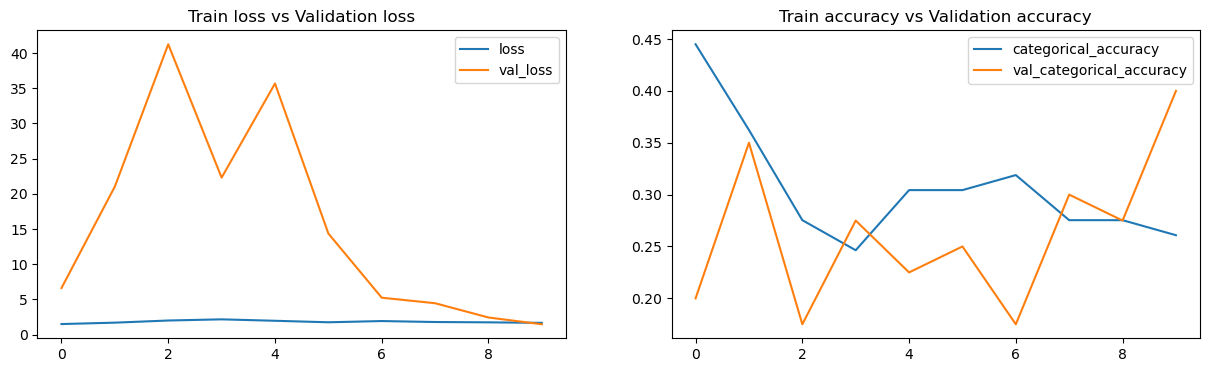

Max. Training Accuracy 0.444947212934494
Max. Validaiton Accuracy 0.4000000059604645


In [17]:
plotModelHistory(model_history)

In [18]:
##releasing memory
model_history= None
model= None
del model; del model_history

## Experimentation

In [19]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential([
        Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
        MaxPooling3D(make3dfilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dfilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dfilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(dense_neurons, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
                ])
    return model

In [14]:
## creating a consolidated function for easy experimentation
def build_model(model, image_height, image_width, n_frames, batch_size, num_epochs,model_name='model_init',augmentation=False):
    optimiser = optimizers.Adam()#write your optimizer
    auc= AUC()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=[auc]) #'categorical_accuracy'
    print (model.summary())
    train_generator = generator(train_path, train_doc, batch_size, n_frames, image_height, image_width,augmentation)
    val_generator = generator(val_path, val_doc, batch_size, n_frames, image_height, image_width,augmentation)

    model_name =  model_name+ '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

#     filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}.h5' #{auc_1:.5f}--{val_auc_1:.5f}
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_freq='epoch',
                                 save_best_only=False, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model_history= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_history

### Experiment to see the effect of batch size, image resolution and number of images in sequence on execution time

In [11]:
# image_height= 160; image_width = 160
# n_frames= 30
# batch_size= 80; num_epochs= 2
# Input_shape = (n_frames, image_height, image_width, 3)
# model= definemodel(Input_shape, filtersize= (3,3,3), dense_neurons=64, dropout= 0.2)
# build_model(model, image_height, image_width, n_frames, Input_shape, batch_size, num_epochs)

In [69]:
# image_height= 124; image_width = 124
# n_frames= 30
# batch_size= 80; num_epochs= 2
# Input_shape = (n_frames, image_height, image_width, 3)
# model= definemodel(Input_shape, filtersize= (3,3,3), dense_neurons=64, dropout= 0.2)
# build_model(model, image_height, image_width, n_frames, Input_shape, batch_size, num_epochs)

In [70]:
# image_height= 160; image_width = 160
# n_frames= 30
# batch_size= 64; num_epochs= 2
# Input_shape = (n_frames, image_height, image_width, 3)
# model= definemodel(Input_shape, filtersize= (3,3,3), dense_neurons=64, dropout= 0.2)
# build_model(model, image_height, image_width, n_frames, Input_shape, batch_size, num_epochs)

In [71]:
# image_height= 160; image_width = 160
# n_frames= 20
# batch_size= 64; num_epochs= 2
# Input_shape = (n_frames, image_height, image_width, 3)
# model= definemodel(Input_shape, filtersize= (3,3,3), dense_neurons=64, dropout= 0.2)
# build_model(model, image_height, image_width, n_frames, Input_shape, batch_size, num_epochs)

In [72]:
# image_height= 124; image_width = 124
# n_frames= 20
# batch_size= 65; num_epochs= 2
# Input_shape = (n_frames, image_height, image_width, 3)
# model= definemodel(Input_shape, filtersize= (3,3,3), dense_neurons=64, dropout= 0.2)
# build_model(model, image_height, image_width, n_frames, Input_shape, batch_size, num_epochs)

We can see that batch_size is not impacting training time but number of frames and image size has an impact on the execution time. So we will use batch size of 65 since it seems to be optimal.

### Model 0_0

In [ ]:
## normalising image using image/255.0
### batch size = 65 ; frames_to_sample = 15 ; image_height = 145 ; image_width = 145

In [26]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

In [27]:
image_height= 145; image_width = 145
n_frames= 15; batch_size= 65
num_epochs= 20
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model0_0= definemodel(Input_shape, dense_neurons, dropout)
model_history0_0= build_model(model0_0, image_height, image_width, n_frames, batch_size, num_epochs,'modelV0_0')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 11, 141, 141, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 71, 71, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 71, 71, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 69, 69, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 35, 35, 32)    0         
 3D)                                                             
                                                      

Epoch 13/20
11/11 [==============================] - ETA: 0s - loss: 0.7779 - categorical_accuracy: 0.7413
Epoch 13: saving model to model_1_2022-11-1315_38_26.223348/model-00013-0.77786-0.74126-4.93437-0.10000.h5
11/11 [==============================] - 63s 6s/step - loss: 0.7779 - categorical_accuracy: 0.7413 - val_loss: 4.9344 - val_categorical_accuracy: 0.1000 - lr: 2.0000e-04
Epoch 14/20
11/11 [==============================] - ETA: 0s - loss: 1.0346 - categorical_accuracy: 0.5664
Epoch 14: saving model to model_1_2022-11-1315_38_26.223348/model-00014-1.03461-0.56643-3.47853-0.30000.h5
11/11 [==============================] - 62s 6s/step - loss: 1.0346 - categorical_accuracy: 0.5664 - val_loss: 3.4785 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 15/20
11/11 [==============================] - ETA: 0s - loss: 0.8850 - categorical_accuracy: 0.6224
Epoch 15: saving model to model_1_2022-11-1315_38_26.223348/model-00015-0.88496-0.62238-2.69738-0.25000.h5
11/11 [===========

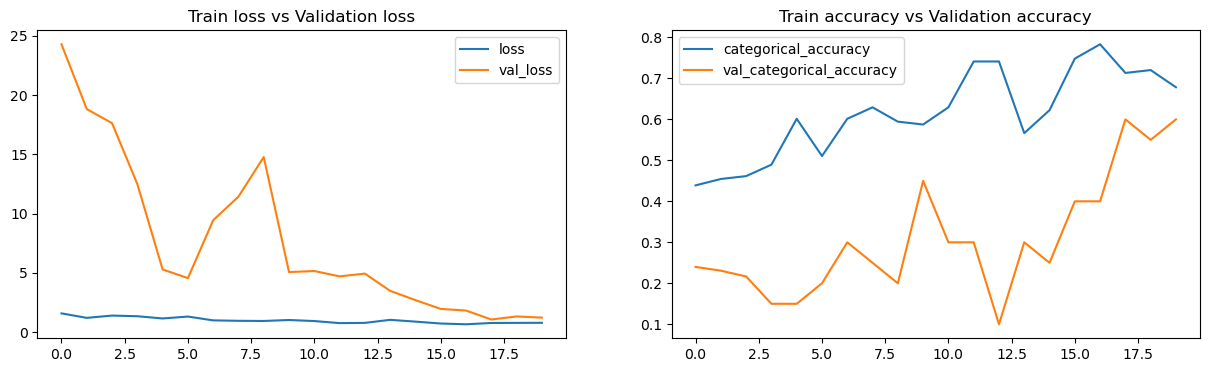

Max. Training Accuracy 0.7832167744636536
Max. Validaiton Accuracy 0.6000000238418579


In [28]:
plotModelHistory(model_history0_0)

In [29]:
##releasing memory
model_history0_0= None
model0_0= None
del model0_0; del model_history0_0

- We can see some level of overfitting happening

### Model 0

In [ ]:
## normalise image using 95th and 5th percentile
### batch size = 65 ; frames_to_sample = 18 ; image_height = 145 ; image_width = 145

In [19]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

In [20]:
image_height= 145; image_width = 145
n_frames= 18; batch_size= 65
num_epochs= 17
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model0= definemodel(Input_shape, dense_neurons, dropout)
model_history0= build_model(model0, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V0')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 14, 141, 141, 16)  6016      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 71, 71, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 7, 71, 71, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 69, 69, 32)     13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 5, 35, 35, 32)    0         
 3D)                                                             
                                                      

11/11 [==============================] - 87s 8s/step - loss: 0.9604 - auc_2: 0.8830 - val_loss: 1.5040 - val_auc_2: 0.7153 - lr: 4.0000e-05
Epoch 15/17
11/11 [==============================] - ETA: 0s - loss: 0.7343 - auc_2: 0.9324
Epoch 15: saving model to model_V0_2022-11-1315_28_19.387116/model-00015-0.73425-1.35891.h5
11/11 [==============================] - 86s 8s/step - loss: 0.7343 - auc_2: 0.9324 - val_loss: 1.3589 - val_auc_2: 0.7578 - lr: 4.0000e-05
Epoch 16/17
11/11 [==============================] - ETA: 0s - loss: 0.7192 - auc_2: 0.9367
Epoch 16: saving model to model_V0_2022-11-1315_28_19.387116/model-00016-0.71917-0.93273.h5
11/11 [==============================] - 86s 8s/step - loss: 0.7192 - auc_2: 0.9367 - val_loss: 0.9327 - val_auc_2: 0.9041 - lr: 4.0000e-05
Epoch 17/17
11/11 [==============================] - ETA: 0s - loss: 0.6903 - auc_2: 0.9435
Epoch 17: saving model to model_V0_2022-11-1315_28_19.387116/model-00017-0.69034-1.56044.h5
11/11 [=====================

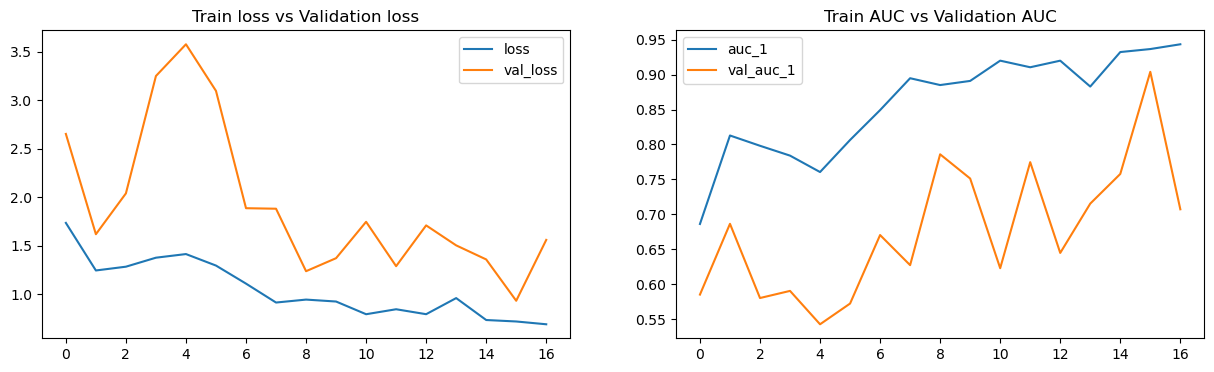

Max. Training Accuracy 0.9435302019119263
Max. Validaiton Accuracy 0.9040625095367432


In [34]:
plotModelHistory(model_history0)

In [ ]:
##releasing memory
model_history0= None
model0= None
del model0; del model_history0

- We get better accuracy when normalise the images using 95th and 5th percentile as compared to when we nomrmalise by diving the images by contact 255

## Normalise image using 95th and 5th percentile and using augmentation

### Model 1

In [ ]:
### batch size = 65 ; frames_to_sample = 18 ; image_height = 145 ; image_width = 145

In [12]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

In [15]:
image_height= 145; image_width = 145
n_frames= 18; batch_size= 65
num_epochs= 20
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model1= definemodel(Input_shape, dense_neurons, dropout)
model_history1= build_model(model1, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V1',augmentation=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 14, 141, 141, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 71, 71, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 7, 71, 71, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 69, 69, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 35, 35, 32)    0         
 3D)                                                             
                                                      

Epoch 15/20
11/11 [==============================] - ETA: 0s - loss: 0.9776 - auc_1: 0.8801
Epoch 15: saving model to model_V1_2022-11-1315_28_19.387116/model-00015-0.97761-0.64244.h5
11/11 [==============================] - 91s 8s/step - loss: 0.9776 - auc_1: 0.8801 - val_loss: 0.6424 - val_auc_1: 0.9634 - lr: 2.0000e-04
Epoch 16/20
11/11 [==============================] - ETA: 0s - loss: 0.6955 - auc_1: 0.9432
Epoch 16: saving model to model_V1_2022-11-1315_28_19.387116/model-00016-0.69551-1.36901.h5
11/11 [==============================] - 90s 8s/step - loss: 0.6955 - auc_1: 0.9432 - val_loss: 1.3690 - val_auc_1: 0.7722 - lr: 2.0000e-04
Epoch 17/20
11/11 [==============================] - ETA: 0s - loss: 0.9534 - auc_1: 0.8861
Epoch 17: saving model to model_V1_2022-11-1315_28_19.387116/model-00017-0.95341-1.38165.h5
11/11 [==============================] - 94s 9s/step - loss: 0.9534 - auc_1: 0.8861 - val_loss: 1.3816 - val_auc_1: 0.7747 - lr: 2.0000e-04
Epoch 18/20
11/11 [=========

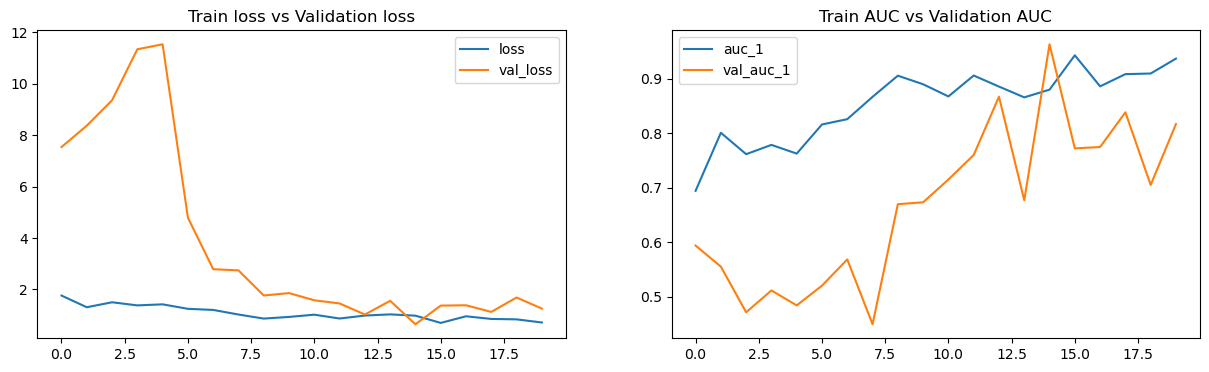

Max. Training Accuracy 0.9432124495506287
Max. Validaiton Accuracy 0.9634374976158142


In [16]:
plotModelHistory(model_history1)

In [17]:
##releasing memory
model_history1= None
model1= None
del model1; del model_history1

- We see a reduction in overfitting

### Model 2: 

In [ ]:
### batch size = 65 ; frames_to_sample = 18 ; image_height = 124 ; image_width = 124

In [46]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

image_height= 124; image_width = 124
n_frames= 18; batch_size= 65
num_epochs= 22
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model2= definemodel(Input_shape, dense_neurons, dropout)
model_history2= build_model(model2, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V2',augmentation=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 14, 120, 120, 16)  6016      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_29 (Bat  (None, 7, 60, 60, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 58, 58, 32)     13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 5, 29, 29, 32)    0         
 g3D)                                                            
                                                      

11/11 [==============================] - 69s 6s/step - loss: 0.7257 - auc_9: 0.9356 - val_loss: 2.0279 - val_auc_9: 0.5494 - lr: 4.0000e-05
Epoch 15/22
11/11 [==============================] - ETA: 0s - loss: 0.9785 - auc_9: 0.8805
Epoch 15: saving model to model_V2_2022-11-1315_28_19.387116/model-00015-0.97850-1.92895.h5
11/11 [==============================] - 68s 6s/step - loss: 0.9785 - auc_9: 0.8805 - val_loss: 1.9289 - val_auc_9: 0.6000 - lr: 4.0000e-05
Epoch 16/22
11/11 [==============================] - ETA: 0s - loss: 0.7991 - auc_9: 0.9188
Epoch 16: saving model to model_V2_2022-11-1315_28_19.387116/model-00016-0.79913-1.72863.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
11/11 [==============================] - 76s 7s/step - loss: 0.7991 - auc_9: 0.9188 - val_loss: 1.7286 - val_auc_9: 0.6622 - lr: 4.0000e-05
Epoch 17/22
11/11 [==============================] - ETA: 0s - loss: 0.5927 - auc_9: 0.9587
Epoch 17: saving model to model_V2_2022-11

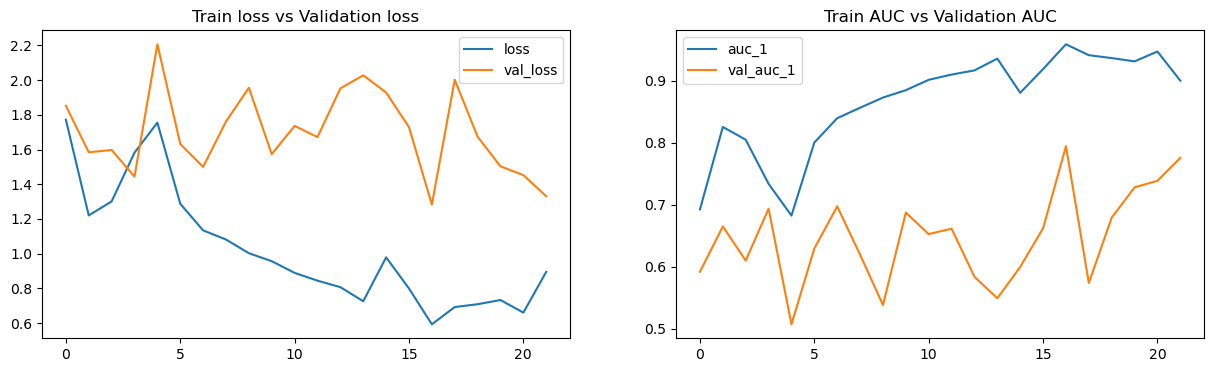

Max. Training Accuracy 0.9587082862854004
Max. Validaiton Accuracy 0.7943750023841858


In [47]:
plotModelHistory(model_history2)

In [48]:
##releasing memory
model_history2= None
model2= None
del model2; del model_history2

- For conv3d when we reduce the image size to 124 the accuracy reduces along with increase in overfitting

### Model 3: 

In [73]:
### added one layer
### batch size = 65 ; frames_to_sample = 22 ; image_height = 145 ; image_width = 145

In [50]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),
                    
            ##added one more layer
            Conv3D(128, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),
                    
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

image_height= 145; image_width = 145
n_frames= 22; batch_size= 65
num_epochs= 26
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model3= definemodel(Input_shape, dense_neurons, dropout)
model_history3= build_model(model3, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V3',augmentation=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 18, 141, 141, 16)  6016      
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 9, 71, 71, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 9, 71, 71, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_23 (Conv3D)          (None, 7, 69, 69, 32)     13856     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 7, 35, 35, 32)    0         
 g3D)                                                            
                                                     

11/11 [==============================] - ETA: 0s - loss: 1.2444 - auc_11: 0.8199
Epoch 13: saving model to model_V3_2022-11-1315_28_19.387116/model-00013-1.24440-1.20856.h5
11/11 [==============================] - 96s 9s/step - loss: 1.2444 - auc_11: 0.8199 - val_loss: 1.2086 - val_auc_11: 0.8162 - lr: 2.0000e-04
Epoch 14/26
11/11 [==============================] - ETA: 0s - loss: 0.9547 - auc_11: 0.8838
Epoch 14: saving model to model_V3_2022-11-1315_28_19.387116/model-00014-0.95468-1.52766.h5
11/11 [==============================] - 95s 9s/step - loss: 0.9547 - auc_11: 0.8838 - val_loss: 1.5277 - val_auc_11: 0.7241 - lr: 2.0000e-04
Epoch 15/26
11/11 [==============================] - ETA: 0s - loss: 0.9493 - auc_11: 0.8877
Epoch 15: saving model to model_V3_2022-11-1315_28_19.387116/model-00015-0.94930-1.65469.h5
11/11 [==============================] - 95s 9s/step - loss: 0.9493 - auc_11: 0.8877 - val_loss: 1.6547 - val_auc_11: 0.7050 - lr: 2.0000e-04
Epoch 16/26
11/11 [============

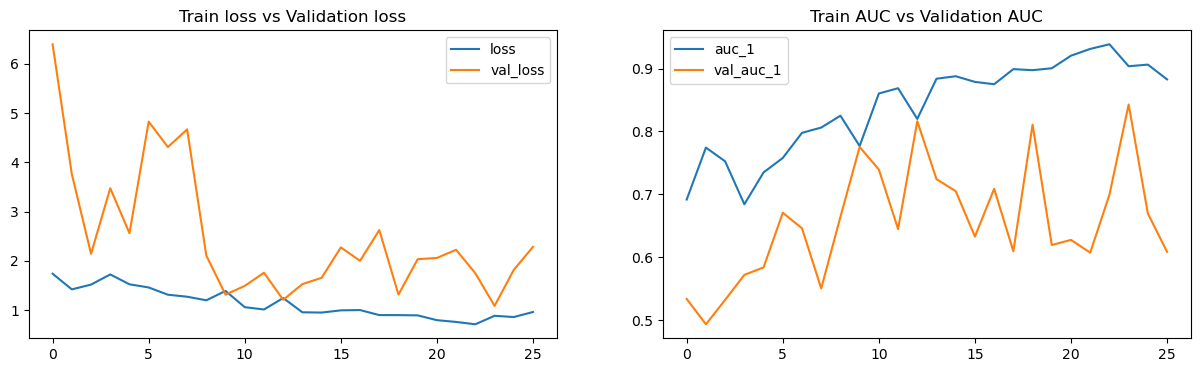

Max. Training Accuracy 0.9385483264923096
Max. Validaiton Accuracy 0.8428124785423279


In [51]:
plotModelHistory(model_history3)

In [52]:
##releasing memory
model_history3= None
model3= None
del model3; del model_history3

### Model 4: 

In [54]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),
                    
            Conv3D(128, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

image_height= 140; image_width = 140
n_frames= 18; batch_size= 65
num_epochs= 30
dense_neurons= 64; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model4= definemodel(Input_shape, dense_neurons, dropout)
model_history4= build_model(model4, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V4',augmentation=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 14, 136, 136, 16)  6016      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 7, 68, 68, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_51 (Bat  (None, 7, 68, 68, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_31 (Conv3D)          (None, 5, 66, 66, 32)     13856     
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 5, 33, 33, 32)    0         
 g3D)                                                            
                                                     

11/11 [==============================] - 68s 6s/step - loss: 1.4130 - auc_13: 0.7544 - val_loss: 1.1918 - val_auc_13: 0.8062 - lr: 4.0000e-05
Epoch 14/30
11/11 [==============================] - ETA: 0s - loss: 1.3102 - auc_13: 0.7861
Epoch 14: saving model to model_V4_2022-11-1315_28_19.387116/model-00014-1.31023-1.52879.h5
11/11 [==============================] - 69s 6s/step - loss: 1.3102 - auc_13: 0.7861 - val_loss: 1.5288 - val_auc_13: 0.6953 - lr: 4.0000e-05
Epoch 15/30
11/11 [==============================] - ETA: 0s - loss: 1.2899 - auc_13: 0.7961
Epoch 15: saving model to model_V4_2022-11-1315_28_19.387116/model-00015-1.28986-1.41214.h5
11/11 [==============================] - 69s 6s/step - loss: 1.2899 - auc_13: 0.7961 - val_loss: 1.4121 - val_auc_13: 0.7012 - lr: 4.0000e-05
Epoch 16/30
11/11 [==============================] - ETA: 0s - loss: 1.1257 - auc_13: 0.8370
Epoch 16: saving model to model_V4_2022-11-1315_28_19.387116/model-00016-1.12566-1.44882.h5
11/11 [============

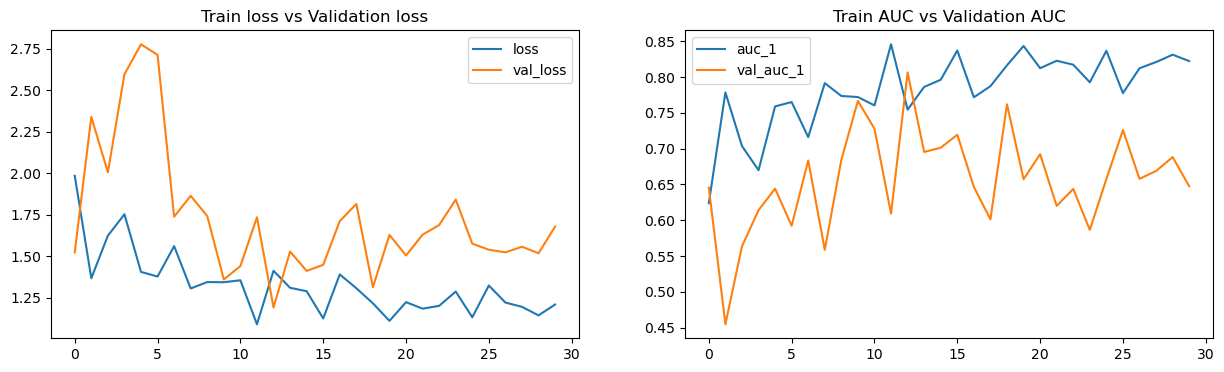

Max. Training Accuracy 0.8456403613090515
Max. Validaiton Accuracy 0.8062499761581421


In [55]:
plotModelHistory(model_history4)

In [56]:
##releasing memory
model_history4= None
model4= None
del model4; del model_history4

## Model 5:

In [ ]:
### batch size = 65 ; frames_to_sample = 30 ; image_height = 145 ; image_width = 145

In [65]:
#write your model here
def definemodel(Input_shape, dense_neurons=32, dropout= 0.3):
    model = Sequential(
                [
            Conv3D(16, make3dfilter(5), activation='relu', input_shape=Input_shape),
            MaxPooling3D(make3dfilter(2), padding='same'),
            BatchNormalization(),

            Conv3D(32, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Conv3D(64, make3dfilter(3), activation='relu'),
            MaxPooling3D(pool_size=(1,2,2), padding='same'),
            BatchNormalization(),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout),

            Dense(dense_neurons, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),

            Dense(5, activation='softmax')
                ]
                    )
    return model

image_height= 145; image_width = 145
n_frames= 30; batch_size= 65
num_epochs= 30
dense_neurons= 128; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model5= definemodel(Input_shape, dense_neurons, dropout)
model_history5= build_model(model5, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V5',augmentation=True)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 26, 141, 141, 16)  6016      
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 13, 71, 71, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_86 (Bat  (None, 13, 71, 71, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_45 (Conv3D)          (None, 11, 69, 69, 32)    13856     
                                                                 
 max_pooling3d_45 (MaxPoolin  (None, 11, 35, 35, 32)   0         
 g3D)                                                            
                                                     

Epoch 15/30
11/11 [==============================] - ETA: 0s - loss: 0.9506 - auc_19: 0.8879 
Epoch 15: saving model to model_V5_2022-11-1315_28_19.387116/model-00015-0.95060-1.45496.h5
11/11 [==============================] - 138s 13s/step - loss: 0.9506 - auc_19: 0.8879 - val_loss: 1.4550 - val_auc_19: 0.7197 - lr: 4.0000e-05
Epoch 16/30
11/11 [==============================] - ETA: 0s - loss: 1.0748 - auc_19: 0.8591 
Epoch 16: saving model to model_V5_2022-11-1315_28_19.387116/model-00016-1.07479-1.44203.h5
11/11 [==============================] - 137s 13s/step - loss: 1.0748 - auc_19: 0.8591 - val_loss: 1.4420 - val_auc_19: 0.7369 - lr: 4.0000e-05
Epoch 17/30
11/11 [==============================] - ETA: 0s - loss: 0.9358 - auc_19: 0.8904 
Epoch 17: saving model to model_V5_2022-11-1315_28_19.387116/model-00017-0.93584-1.27640.h5
11/11 [==============================] - 137s 13s/step - loss: 0.9358 - auc_19: 0.8904 - val_loss: 1.2764 - val_auc_19: 0.7981 - lr: 4.0000e-05
Epoch 18/3

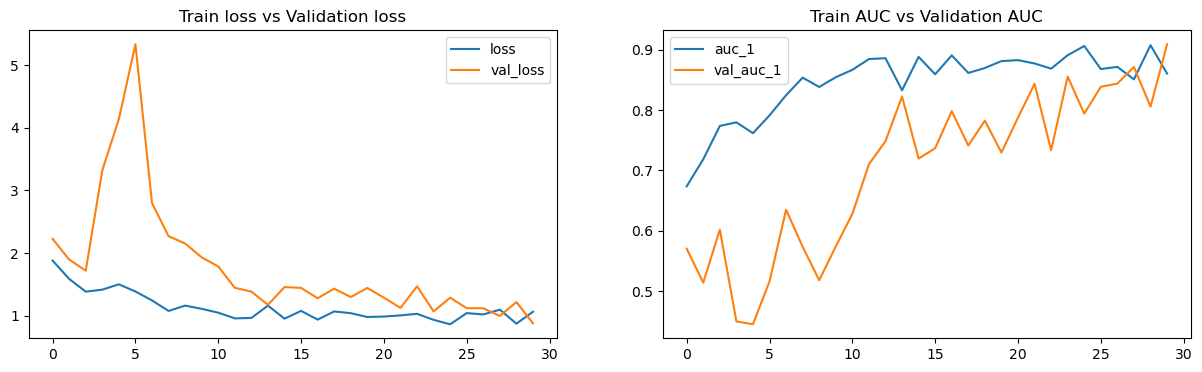

Max. Training Accuracy 0.907244861125946
Max. Validaiton Accuracy 0.9087499976158142


In [66]:
plotModelHistory(model_history5)

In [67]:
##releasing memory
model_history5= None
model5= None
del model5; del model_history5

In [35]:
def make2dfilter(x):
    return tuple([x]*2)

## Model 6: Conv2D+LSTM

In [ ]:
### batch size = 65 ; frames_to_sample = 30 ; image_height = 145 ; image_width = 145

In [62]:
#write your model here
def definemodel(Input_shape, dense_neurons=64, dropout= 0.3):
    model = Sequential(
            [
            TimeDistributed(Conv2D(16, make2dfilter(3), padding='same', activation='relu'), 
                            input_shape=Input_shape),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(make2dfilter(2))),

            TimeDistributed(Conv2D(32, make2dfilter(3), padding='same', activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(make2dfilter(2))),

            TimeDistributed(Conv2D(64, make2dfilter(3), padding='same', activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(make2dfilter(2))),

            TimeDistributed(Flatten()),
            LSTM(128),
            Dropout(dropout),
            
            Dense(dense_neurons, activation='relu'),
            Dropout(dropout),

            Dense(5, activation='softmax')
        ]
    )
    return model

image_height= 145; image_width = 145
n_frames= 30; batch_size= 65
num_epochs= 32
dense_neurons= 128; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model6= definemodel(Input_shape, dense_neurons, dropout)
model_history6= build_model(model6, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V6',augmentation=True)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 145, 145, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 145, 145, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 72, 72, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 72, 72, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 72, 72, 32) 

Epoch 15/32
11/11 [==============================] - ETA: 0s - loss: 1.3104 - auc_18: 0.7767
Epoch 15: saving model to model_V6_2022-11-1315_28_19.387116/model-00015-1.31039-1.48753.h5
11/11 [==============================] - 94s 9s/step - loss: 1.3104 - auc_18: 0.7767 - val_loss: 1.4875 - val_auc_18: 0.6819 - lr: 4.0000e-05
Epoch 16/32
11/11 [==============================] - ETA: 0s - loss: 1.2844 - auc_18: 0.7780
Epoch 16: saving model to model_V6_2022-11-1315_28_19.387116/model-00016-1.28441-1.80760.h5
11/11 [==============================] - 96s 9s/step - loss: 1.2844 - auc_18: 0.7780 - val_loss: 1.8076 - val_auc_18: 0.4631 - lr: 4.0000e-05
Epoch 17/32
11/11 [==============================] - ETA: 0s - loss: 1.2176 - auc_18: 0.8198
Epoch 17: saving model to model_V6_2022-11-1315_28_19.387116/model-00017-1.21761-1.73105.h5
11/11 [==============================] - 87s 9s/step - loss: 1.2176 - auc_18: 0.8198 - val_loss: 1.7311 - val_auc_18: 0.5219 - lr: 4.0000e-05
Epoch 18/32
11/11 [

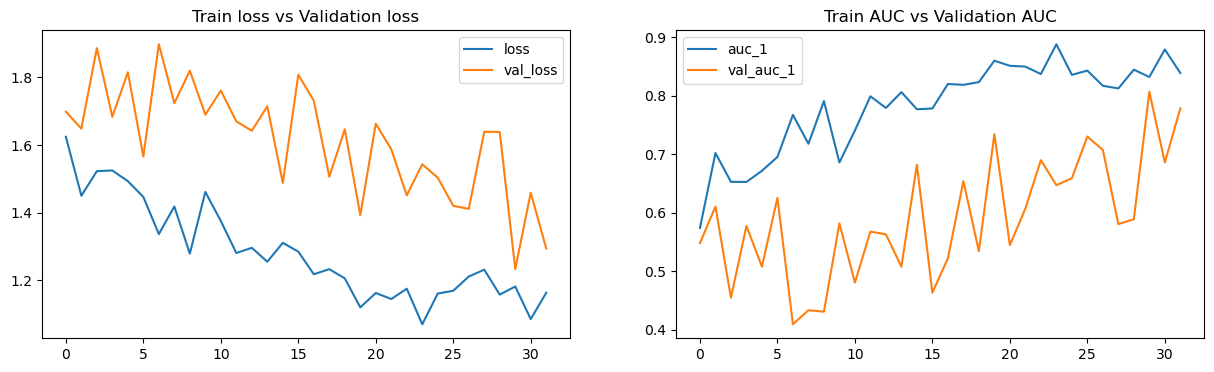

Max. Training Accuracy 0.887775719165802
Max. Validaiton Accuracy 0.8065624833106995


In [63]:
plotModelHistory(model_history6)

In [64]:
##releasing memory
model_history6= None
model6= None
del model6; del model_history6

## Model 7: Transfer Learning using MobileNet with LSTM

In [ ]:
### batch size = 65 ; frames_to_sample = 19 ; image_height = 124 ; image_width = 124

In [37]:
#write your model here
def definemodel(Input_shape, dense_neurons=64, dropout= 0.3):
    from tensorflow.keras.applications import mobilenet
    ##getting pre-trained model
    mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model = Sequential([
                    TimeDistributed(mobilenet, input_shape= Input_shape)
                    ]
                )
    for layer in model.layers:
        layer.trainable = False
        
    ##addign custom layers in the pre-trrained model
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(make2dfilter(2))))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(dense_neurons))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

image_height= 124; image_width = 124
n_frames= 19; batch_size= 65
num_epochs= 27
dense_neurons= 128; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model7= definemodel(Input_shape, dense_neurons, dropout)
model_history7= build_model(model7, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V7',augmentation=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 19, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 19, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 19, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 19, 1024)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)              

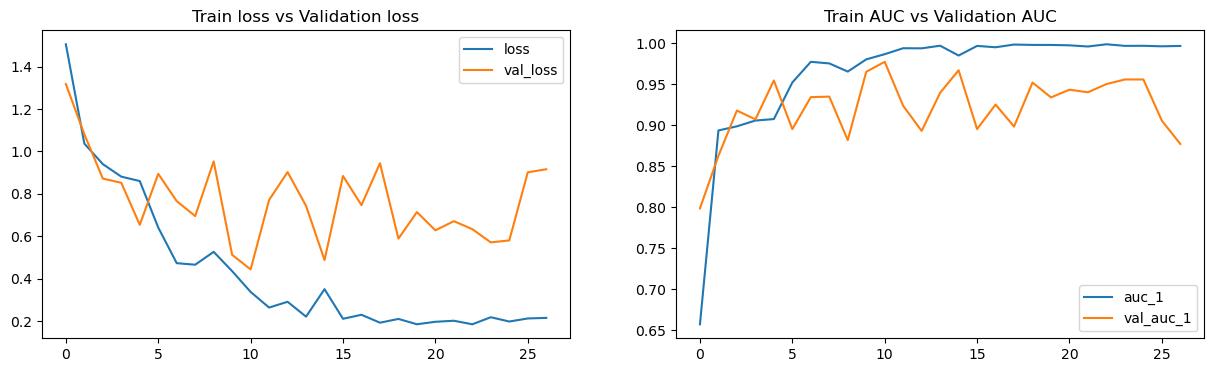

Max. Training Accuracy 0.9989118576049805
Max. Validaiton Accuracy 0.9775000214576721


In [38]:
plotModelHistory(model_history7)

In [39]:
##releasing memory
model_history7= None
model7= None
del model7; del model_history7

## Model 8:  Transfer Learning using MobileNet with GRU

In [74]:
### batch size = 65 ; frames_to_sample = 19 ; image_height = 124 ; image_width = 124

In [41]:
#write your model here
def definemodel(Input_shape, dense_neurons=64, dropout= 0.3):
    from tensorflow.keras.applications import mobilenet
    ##getting pre-trained model
    mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model = Sequential([
                    TimeDistributed(mobilenet, input_shape= Input_shape)
                    ]
                )
    for layer in model.layers:
        layer.trainable = False
        
    ##addign custom layers in the pre-trrained model
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(make2dfilter(2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(dense_neurons))
    model.add(Dropout(dropout))
    
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

image_height= 124; image_width = 124
n_frames= 19; batch_size= 65
num_epochs= 23
dense_neurons= 128; dropout= 0.25
Input_shape = (n_frames, image_height, image_width, 3)
model8= definemodel(Input_shape, dense_neurons, dropout)
model_history8= build_model(model8, image_height, image_width, n_frames, batch_size, 
                            num_epochs,'model_V8',augmentation=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 19, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 19, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 19, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 19, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              


Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
11/11 [==============================] - 76s 8s/step - loss: 0.0823 - auc_6: 1.0000 - val_loss: 0.8070 - val_auc_6: 0.9394 - lr: 2.0000e-04
Epoch 19/23
11/11 [==============================] - ETA: 0s - loss: 0.0673 - auc_6: 0.9998
Epoch 19: saving model to model_V8_2022-11-1315_28_19.387116/model-00019-0.06727-0.46731.h5
11/11 [==============================] - 71s 7s/step - loss: 0.0673 - auc_6: 0.9998 - val_loss: 0.4673 - val_auc_6: 0.9797 - lr: 4.0000e-05
Epoch 20/23
11/11 [==============================] - ETA: 0s - loss: 0.0823 - auc_6: 0.9994
Epoch 20: saving model to model_V8_2022-11-1315_28_19.387116/model-00020-0.08232-0.73180.h5
11/11 [==============================] - 68s 7s/step - loss: 0.0823 - auc_6: 0.9994 - val_loss: 0.7318 - val_auc_6: 0.9434 - lr: 4.0000e-05
Epoch 21/23
11/11 [==============================] - ETA: 0s - loss: 0.0737 - auc_6: 0.9999
Epoch 21: saving model to model_V8_2022-1

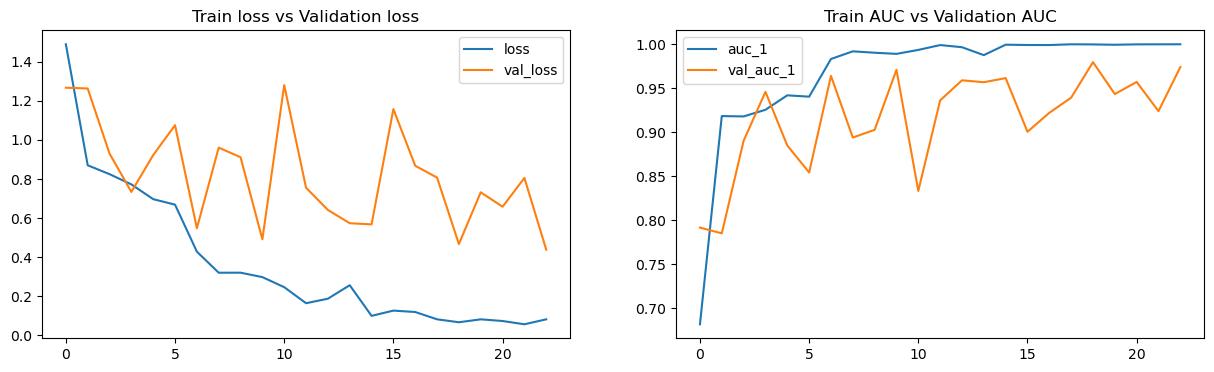

Max. Training Accuracy 0.9999756217002869
Max. Validaiton Accuracy 0.979687511920929


In [42]:
plotModelHistory(model_history8)

In [43]:
##releasing memory
model_history8= None
model8= None
del model8; del model_history8

## Good performing models

| Model Details | No. of Parameters | Train/Val Accuracy  | Results |
| :- | -: | :- |  :-: |
| **Model 8** | 3,693,253 | Train Accuracy - 0.99 |  Epoch 14: loss: 0.2568 - auc_6: 0.9876 - val_loss: 0.5737 - val_auc_6: 0.9569|
|Transfer learning using MobileNet with GRU| | Val. Accuracy - 0.97| Epoch 10: loss: 0.2981 - auc_6: 0.9891 - val_loss: 0.4914 - val_auc_6: 0.9709|
|         |           |   | Epoch 7: loss: 0.4283 - auc_6: 0.9833 - val_loss: 0.5481 - val_auc_6: 0.9641|
| **Model 7** | 3,840,453 | Train Accuracy - 0.99 | Epoch 14: loss: 0.2568 - auc_6: 0.9876 - val_loss: 0.5737 - val_auc_6: 0.9569|
|Transfer learning using MobileNet with LSTM | | Val. Accuracy - 0.97| Epoch 10: loss: 0.2981 - auc_6: 0.9891 - val_loss: 0.4914 - val_auc_6: 0.9709|
|         |           |  | Epoch 7: loss: 0.4283 - auc_6: 0.9833 - val_loss: 0.5481 - val_auc_6: 0.9641|
| **Model 6** | 10,724,069 | Train Accuracy - 0.88 | Epoch 30: loss: 1.1812 - auc_18: 0.8319 - val_loss: 1.2327 - val_auc_18: 0.8066| 
|Conv 2D + LSTM|  | Val. Accuracy - 0.80|  |
| **Model 4** | 1,109,285 | Train Accuracy - 0.84 | Epoch 10: loss: 1.3440 - auc_13: 0.7720 - val_loss: 1.3606 - val_auc_13: 0.7666|
|Conv 3D|  | Val. Accuracy - 0.80|   |
| **Model 3** | 3,452,709 | Train Accuracy - 0.93 | Epoch 13: loss: 1.2444 - auc_11: 0.8199 - val_loss: 1.2086 - val_auc_11: 0.8162|
|Conv 3D|  | Val. Accuracy - 0.84|   |
| **Model 1** | 7,187,621 | Train Accuracy - 0.94 | Epoch 13: loss: 0.9816 - auc_1: 0.8857 - val_loss: 1.0213 - val_auc_1: 0.8672|
|Conv 3D|  | Val. Accuracy - 0.96|   |
| **Model 0** | 7,187,621 | Train Accuracy - 0.94 | Epoch 16: loss: 0.7192 - auc_2: 0.9367 - val_loss: 0.9327 - val_auc_2: 0.9041|
|Conv 3D|  | Val. Accuracy - 0.90|   |

**Submitted By:**
- Vibhu Goel (Group Facilitator)
- Suresh Babu
- Anugata Mahapatra